## ✅ Correctif Windows/MKL (à exécuter en premier)

In [45]:
import os
os.environ["OMP_NUM_THREADS"] = "2"
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["OPENBLAS_NUM_THREADS"] = "2"
print("Threads fixés -> OMP/MKL/OPENBLAS = 2")


Threads fixés -> OMP/MKL/OPENBLAS = 2



# 📊 Projet Data Mining — Commerce (Google Colab)

**Objectifs :**
1) **Analyse des ventes & clients** (EDA)  
2) **Segmentation** des clients (clustering K-Means)  
3) **Recommandations d'actions** marketing personnalisées (basées sur la similarité et sur les profils de clusters)  
4) **Mini-modèles prédictifs** (régression du montant d'achat, classification adhésion fidélité)

> 💡 Ce notebook est prêt pour **Google Colab**. Exécutez les cellules dans l'ordre.



## 0) Préparation de l'environnement

- Si vous êtes dans **Colab**, vous pouvez **uploader** directement votre CSV.  
- Sinon, précisez le **chemin local** du fichier.


In [46]:

# @title 📦 Import des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression, LogisticRegression
import seaborn as sns

pd.set_option("display.max_columns", 100)
print("Versions -> pandas:", pd.__version__)

from threadpoolctl import threadpool_limits  # limitation propre des threads autour de KMeans


Versions -> pandas: 2.3.0+4.g1dfc98e16a


In [47]:

# @title 📄 Option B : Indiquer un chemin/localisation du CSV
# Par défaut, on utilise le nom de fichier standard : 'E-commerce_Dataset.csv'
csv_path = "E-commerce_Dataset.csv"  # remplacez si besoin (ex: '/content/E-commerce_Dataset.csv')
print("Chemin CSV ->", csv_path)


Chemin CSV -> E-commerce_Dataset.csv



## 1) Chargement & aperçu des données


In [48]:

# Chargement
df = pd.read_csv(csv_path)

# Aperçu
display(df.head())
display(df.tail())

print("\nDimensions:", df.shape)
print("\nTypes de colonnes:")
print(df.dtypes)


,CustomerID,Age,Gender,PurchaseAmount,PurchaseFrequency,ProductQualityRating,DeliveryTimeRating,CustomerServiceRating,WebsiteEaseOfUseRating,ReturnRate,DiscountUsage,LoyaltyProgramMember
0,1,38,Female,749.097626,24,2,1,3,5,0.12,135.392573,No
1,2,30,Male,735.224916,18,5,4,4,5,0.37,193.450663,Yes
2,3,55,Male,1145.520305,22,3,5,4,1,0.10,147.246263,Yes
3,4,39,Female,925.460535,14,4,3,2,4,0.38,56.362894,Yes
4,5,51,Male,108.359916,9,3,3,2,5,0.42,338.731055,No


,CustomerID,Age,Gender,PurchaseAmount,PurchaseFrequency,ProductQualityRating,DeliveryTimeRating,CustomerServiceRating,WebsiteEaseOfUseRating,ReturnRate,DiscountUsage,LoyaltyProgramMember
495,496,25,Female,1331.673244,2,1,4,5,5,0.20,483.526690,No
496,497,53,Male,1031.814050,2,3,3,1,3,0.13,372.031011,Yes
497,498,42,Female,1554.718256,26,5,1,2,3,0.11,373.020405,No
498,499,35,Male,1744.891965,11,2,2,3,2,0.36,414.246263,No
499,500,60,Male,110.985526,14,3,5,1,4,0.17,85.895089,Yes



Dimensions: (500, 12)

Types de colonnes:
CustomerID                  int64
Age                         int64
Gender                     object
PurchaseAmount            float64
PurchaseFrequency           int64
ProductQualityRating        int64
DeliveryTimeRating          int64
CustomerServiceRating       int64
WebsiteEaseOfUseRating      int64
ReturnRate                float64
DiscountUsage             float64
LoyaltyProgramMember       object
dtype: object



## 2) Qualité des données : valeurs manquantes, doublons, types


In [49]:

# Valeurs manquantes
na_counts = df.isna().sum().sort_values(ascending=False)
display(na_counts.to_frame("Nb_NA"))

# Doublons potentiels
dup_count = df.duplicated().sum()
print("Doublons:", dup_count)

# Correction basique des types si besoin
# (Ici, nous gardons les types par défaut. Vous pouvez caster si nécessaire.)


,Nb_NA
CustomerID,0
Age,0
Gender,0
PurchaseAmount,0
PurchaseFrequency,0
ProductQualityRating,0
DeliveryTimeRating,0
CustomerServiceRating,0
WebsiteEaseOfUseRating,0
ReturnRate,0


Doublons: 0



## 3) Exploration Descriptive (EDA) — ventes & satisfaction


Numériques: ['CustomerID', 'Age', 'PurchaseAmount', 'PurchaseFrequency', 'ProductQualityRating', 'DeliveryTimeRating', 'CustomerServiceRating', 'WebsiteEaseOfUseRating', 'ReturnRate', 'DiscountUsage']
Catégorielles: ['Gender', 'LoyaltyProgramMember']


,count,mean,std,min,25%,50%,75%,max
CustomerID,500.0,250.500000,144.481833,1.000000,125.750000,250.500000,375.250000,500.000000
Age,500.0,44.170000,14.813777,18.000000,32.000000,44.000000,58.000000,69.000000
PurchaseAmount,500.0,1065.050731,583.199658,51.799790,535.083407,1100.884065,1584.348124,1999.655968
PurchaseFrequency,500.0,14.308000,8.151197,1.000000,7.000000,14.000000,22.000000,29.000000
ProductQualityRating,500.0,2.934000,1.410540,1.000000,2.000000,3.000000,4.000000,5.000000
DeliveryTimeRating,500.0,3.008000,1.372481,1.000000,2.000000,3.000000,4.000000,5.000000
CustomerServiceRating,500.0,3.078000,1.415600,1.000000,2.000000,3.000000,4.000000,5.000000
WebsiteEaseOfUseRating,500.0,3.082000,1.415374,1.000000,2.000000,3.000000,4.000000,5.000000
ReturnRate,500.0,0.252280,0.149674,0.000000,0.110000,0.260000,0.380000,0.500000
DiscountUsage,500.0,251.181010,141.531993,0.772696,133.672231,251.940355,371.692341,499.813315


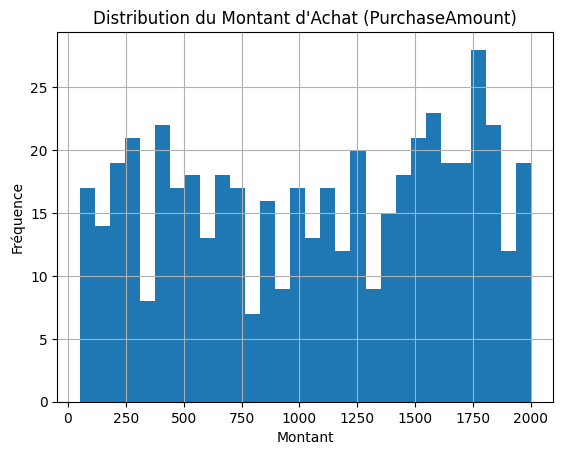

<Figure size 640x480 with 0 Axes>

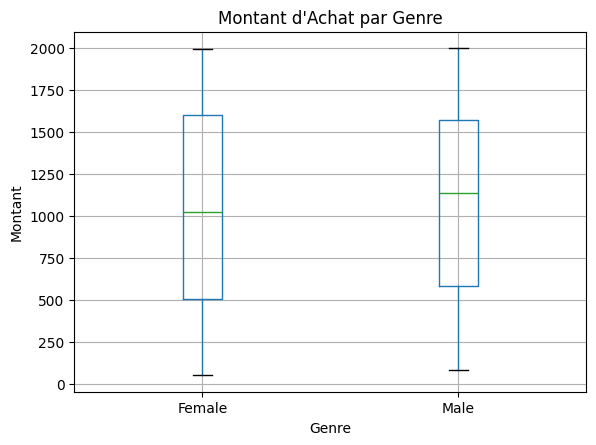

<Figure size 640x480 with 0 Axes>

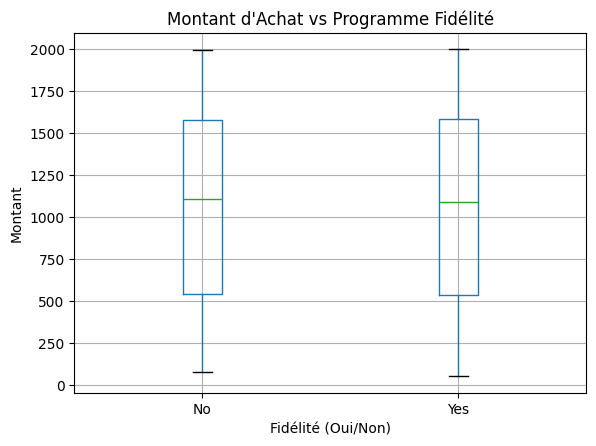

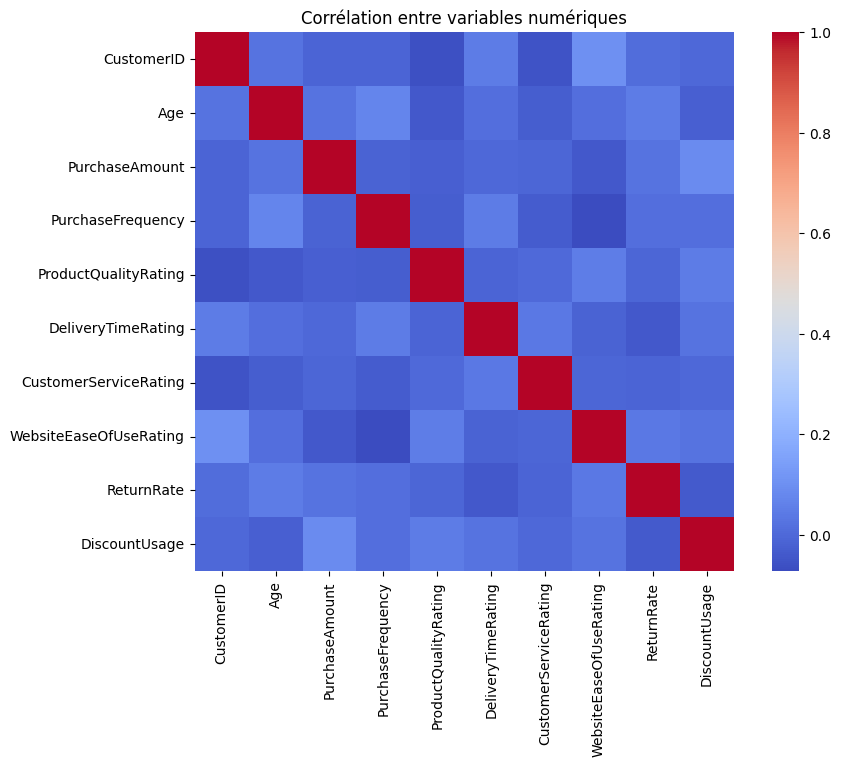

In [50]:

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in numeric_cols]

print("Numériques:", numeric_cols)
print("Catégorielles:", cat_cols)

# Statistiques descriptives
display(df[numeric_cols].describe().T)

# Distribution du montant d'achat
plt.figure()
df['PurchaseAmount'].hist(bins=30)
plt.title("Distribution du Montant d'Achat (PurchaseAmount)")
plt.xlabel("Montant")
plt.ylabel("Fréquence")
plt.show()

# Boxplot par genre
plt.figure()
df.boxplot(column='PurchaseAmount', by='Gender')
plt.title("Montant d'Achat par Genre")
plt.suptitle("")
plt.xlabel("Genre")
plt.ylabel("Montant")
plt.show()

# Impact du programme fidélité
plt.figure()
df.boxplot(column='PurchaseAmount', by='LoyaltyProgramMember')
plt.title("Montant d'Achat vs Programme Fidélité")
plt.suptitle("")
plt.xlabel("Fidélité (Oui/Non)")
plt.ylabel("Montant")
plt.show()

# Matrice de corrélation
plt.figure(figsize=(10,7))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", square=True)
plt.title("Corrélation entre variables numériques")
plt.show()


### 🔗 Contenu de l'équipe (inséré après EDA)

## Un autre objectif fixé sur le dataset: prédiction ou analyse de la satisfaction du client

##### Problématique centrale possible
##### Comment identifier et expliquer les facteurs qui influencent la satisfaction et 
##### la fidélité des clients dans le e-commerce, afin de réduire le taux de retour et améliorer l’expérience client ?


### 1- Satisfaction client

##### Quelles variables influencent le plus la satisfaction (qualité produit, temps de livraison, service client, ergonomie du site) ?

##### Peut-on prédire la satisfaction globale à partir de ces notes partielles ?

### 2- Retour produit (ReturnRate)

##### Quels facteurs expliquent un taux de retour élevé ?

##### Existe-t-il des profils de clients plus enclins à retourner leurs achats ?

##### Fidélisation (LoyaltyProgram, DiscountUsage)

##### Les réductions et programmes de fidélité augmentent-ils la satisfaction et la rétention des clients ?

##### Y a-t-il une corrélation entre utilisation des remises et taux de retour ?

### Les points pour bien cadrer notre objectif :
##### •	Classification si la satisfaction est en catégories exemple : satisfait / neutre / insatisfait.
##### •	Régression si on utilise un score numérique exemple : note de 1 à 5.



## Choix de  la variable cible
##### •	ReturnRate: indicateur indirect de satisfaction (plus il est élevé, plus le client est insatisfait).
##### •	ProductQualityRating, DeliveryTimeRating, CustomerServiceRating, WebsiteEaseOfUseRating.

### Déterminer le type de problème
##### •	Si ReturnRate est numérique (ex. 0.12, 0.30…), c’est un problème de régression.
### Définir les features explicatives en prénant ReturnRate comme étiquette cible :
##### •	Données client : Age, Gender, LoyaltyProgramMember
##### •	Données achat : PurchaseAmount, PurchaseFrequency, DiscountUsage
##### •	Expérience d’achat : ProductQualityRating, DeliveryTimeRating, CustomerServiceRating, WebsiteEaseOfUseRating


In [51]:

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

### Step 2 : Distribution du ReturnRate
##### Voir si le ReturnRate est concentré sur certaines valeurs.


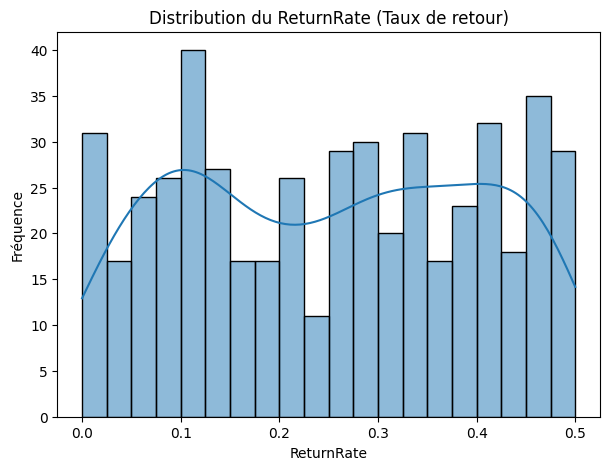

In [52]:
plt.figure(figsize=(7,5))
sns.histplot(df["ReturnRate"], bins=20, kde=True)
plt.title("Distribution du ReturnRate (Taux de retour)")
plt.xlabel("ReturnRate")
plt.ylabel("Fréquence")
plt.show()


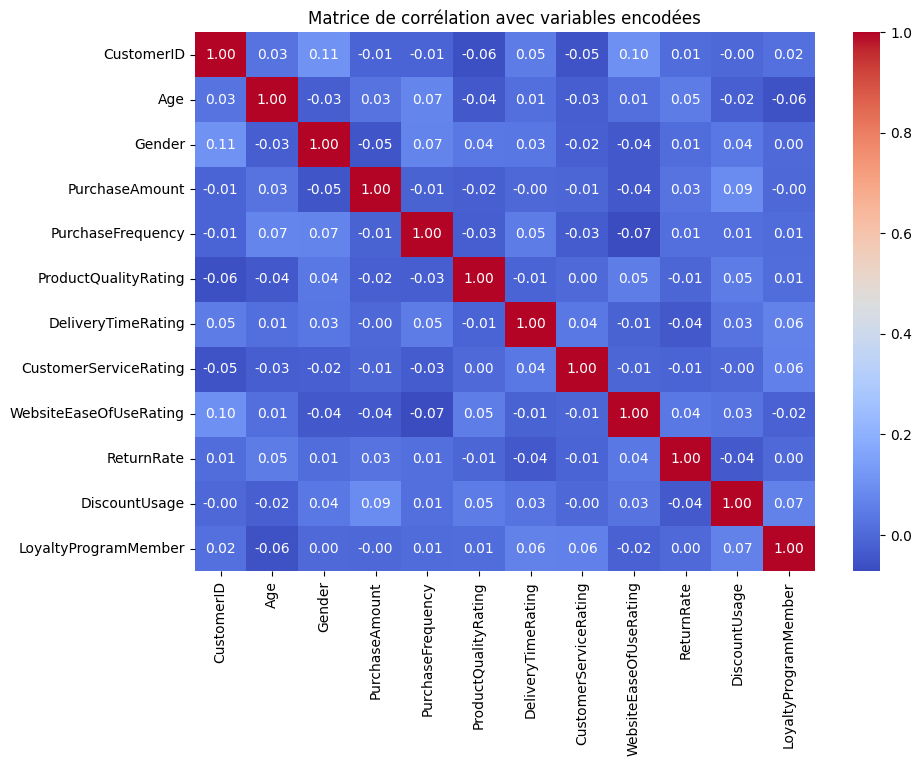

In [53]:
#encodage
df_encoded = df.copy()
df_encoded["Gender"] = df_encoded["Gender"].map({"Male":0, "Female":1})
df_encoded["LoyaltyProgramMember"] = df_encoded["LoyaltyProgramMember"].map({"No":0, "Yes":1})

corr_matrix = df_encoded.corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation avec variables encodées")
plt.show()


In [54]:

# La colonne ReturnRate représente les corrélations de chaque variable avec le taux de retour.

# Plus la valeur est proche de +1 (corrélation positive forte) ou -1 (corrélation négative forte), plus la variable influence ReturnRate.

# Si c’est proche de 0, il n’y a presque pas de lien linéaire.

# D’après ce heatmap

# En lisant la colonne ReturnRate :

# PurchaseFrequency ≈ 0.03 (légère corrélation positive :plus d’achats fréquents pourrait légèrement augmenter le retour).

# Age ≈ 0.05 (faible corrélation positive: les clients plus âgés pourraient un peu plus retourner).

# CustomerServiceRating ≈ 0.04 (faible corrélation positive: étonnant, peut-être lié à insatisfaction après retour).

# Les autres variables (ProductQualityRating, DeliveryTimeRating, WebsiteEaseOfUseRating, DiscountUsage, LoyaltyProgramMember) sont autour de 0.00 à 0.01, donc quasi aucun impact.

# Donc, dans cette version du dataset, aucune variable n’a une forte corrélation linéaire avec ReturnRate.
# Cela signifie que la corrélation simple ne suffit pas pour identifier les vrais déterminants des retours.

# Étape suivante

# Pour vraiment savoir quelles variables influencent ReturnRate, il faudra :

# Tester un modèle prédictif (ex : RandomForest, XGBoost).

# Regarder les importances de features:ça donne une meilleure idée que la corrélation simple.

In [55]:
#sélection des données pertinentes(ici, toutes les données peuvent e ,entre en jeu
#car on ne sait pas les vrais déterminants qui impactent la satisfaction du client.

In [56]:
# Pour vraiment savoir quelles variables influencent ReturnRate, il faudra :
# Tester un modèle prédictif,exemple : RandomForest, XGBoost.
# Regarder les importances de features:ça donne une meilleure idée que la corrélation simple.

In [57]:
#Prétraitement des données (nettoyage des données)

In [58]:
#Influence des features sur ReturnRate

MAE=0.1465 | RMSE=0.1693 | R²=-0.263


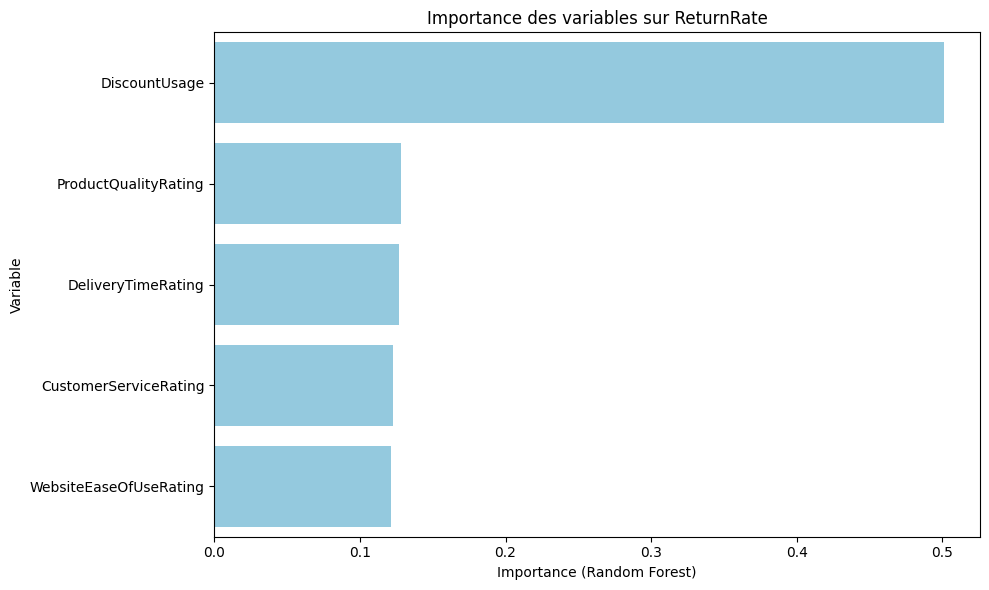

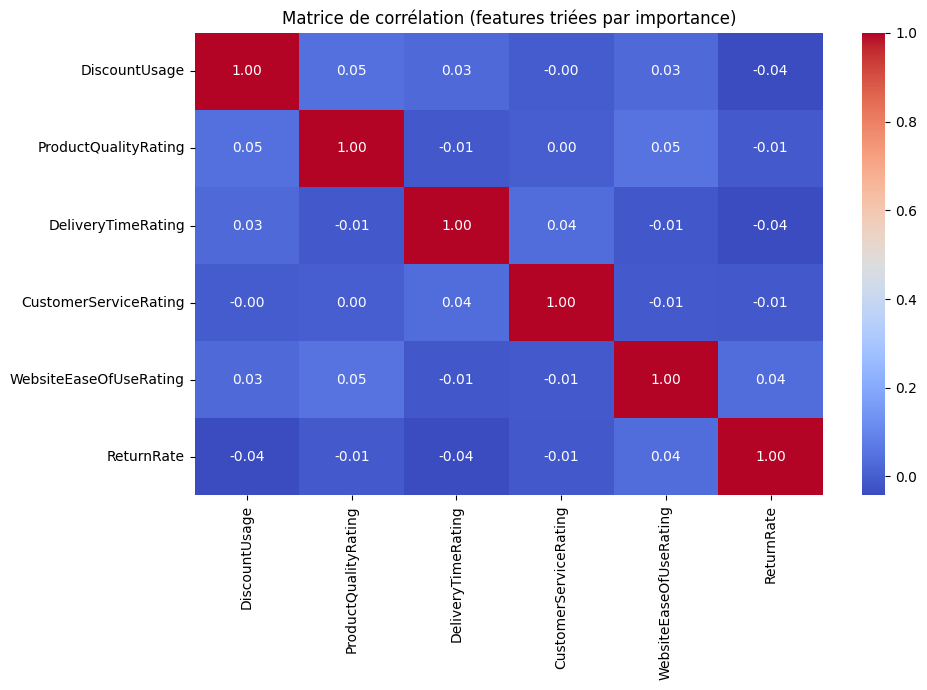

In [59]:
# -------------------------------
# 1) Features / Target
# -------------------------------
features = ["ProductQualityRating", "DeliveryTimeRating", "CustomerServiceRating",
            "WebsiteEaseOfUseRating", "DiscountUsage"]   # à adapter selon ton dataset
target = "ReturnRate"

X = df[features]
y = df[target]

# -------------------------------
# 2) Entraînement Random Forest
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# (optionnel) métriques
y_pred = rf.predict(X_test)
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))   # compatible toutes versions
r2   = r2_score(y_test, y_pred)
print(f"MAE={mae:.4f} | RMSE={rmse:.4f} | R²={r2:.3f}")

# -------------------------------
# 3) Importance des variables
# -------------------------------
importances = rf.feature_importances_
feature_importance_df = (pd.DataFrame({"Feature": features, "Importance": importances})
                         .sort_values(by="Importance", ascending=False))


plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature",
            data=feature_importance_df,
            color="skyblue")     # une seule couleur -> pas de FutureWarning
plt.title("Importance des variables sur ReturnRate")
plt.xlabel("Importance (Random Forest)")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

# -------------------------------
# 4) Matrice de corrélation (ordonnée par importance)
# -------------------------------
ordered_feats = feature_importance_df["Feature"].tolist()
corr_mat = df[ordered_feats + [target]].corr()

plt.figure(figsize=(10, 7))
sns.heatmap(corr_mat, annot=True, cmap="coolwarm", fmt=".2f", square=False)
plt.title("Matrice de corrélation (features triées par importance)")
plt.tight_layout()
plt.show()


In [60]:
#le feature qui a plus d'influence sur ReturnRante qui justifie la satisfaction du client est PurchaseAmount selon ce pipeline.

In [61]:
## l’interprétation des importances de variables que  Random Forest a  donné.

In [62]:
# Random Forest permet de mesurer l’influence de chaque feature sur la variable cible ReturnRate.

# Le barplot montre visuellement quelles features sont les plus importantes.

# La matrice de corrélation permet de voir les relations linéaires entre ReturnRate et les autres variables.

In [63]:


# Ici, on prend les variables qui pourraient influencer le taux de retour
features = ['ProductQualityRating', 'DeliveryTimeRating', 'CustomerServiceRating', 
            'WebsiteEaseOfUseRating', 'DiscountUsage']
target = 'ReturnRate'

X = df[features]
y = df[target]

# ==============================
# 3. Séparer train/test
# ==============================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==============================
# 4. Entraîner le modèle Random Forest
# ==============================
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# ==============================
# 5. Prédire sur le jeu de test
# ==============================
y_pred = rf.predict(X_test)

# ==============================
# 6. Prédire la moyenne de ReturnRate
# ==============================
predicted_mean = y_pred.mean()
print("Prédiction de la moyenne de ReturnRate:", predicted_mean)

# ==============================
# 7. Évaluer le modèle
# ==============================
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE:", mse)
print("R²:", r2)


Prédiction de la moyenne de ReturnRate: 0.24463000000000001
MSE: 0.028674805400000006
R²: -0.2633764786121138


In [64]:
# Prédiction moyenne de ReturnRate : 0.2446 
# Le modèle estime qu’en moyenne, les clients retournent environ 24,5 % de leurs achats sur le jeu de test.

In [65]:
 # 2 - Définir features et cible
features = ['ProductQualityRating', 'DeliveryTimeRating', 'CustomerServiceRating', 
            'WebsiteEaseOfUseRating', 'DiscountUsage']
target = 'ReturnRate'

X = df[features]
y = df[target]

# ==============================
# 3. Séparer train/test
# ==============================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==============================
# 4. Entraîner Random Forest
# ==============================
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# ==============================
# 5. Prédire ReturnRate pour chaque client du test
# ==============================
y_pred = rf.predict(X_test)

# Ajouter les prédictions au dataframe test
df_test = X_test.copy()
df_test['ActualReturnRate'] = y_test.values
df_test['PredictedReturnRate'] = y_pred

# ==============================
# 6. Définir un seuil pour identifier les clients à risque
# ==============================
# Exemple : seuil = 30% (0.3)
risk_threshold = 0.3
df_test['HighRisk'] = df_test['PredictedReturnRate'] > risk_threshold

# ==============================
# 7. Afficher les clients à risque
# ==============================
high_risk_clients = df_test[df_test['HighRisk']]
print("Nombre de clients à risque :", len(high_risk_clients))
print(high_risk_clients[['PredictedReturnRate', 'ActualReturnRate']])

Nombre de clients à risque : 13
     PredictedReturnRate  ActualReturnRate
124               0.3006              0.11
84                0.3337              0.21
371               0.3590              0.11
475               0.3347              0.49
63                0.3016              0.28
485               0.3068              0.26
204               0.3171              0.39
79                0.3324              0.23
46                0.3038              0.29
304               0.3057              0.25
82                0.3910              0.42
324               0.3213              0.46
438               0.3570              0.20


In [66]:
# On a identifié 13 clients à risque dont le PredictedReturnRate est supérieur à 0,3 (30 %).
# signification concrete :

# Interprétation

# PredictedReturnRate : ce que le modèle estime pour chaque client.

# ActualReturnRate : le taux réel observé.

# Exemples :

# Client 84 : prédit 0,334 donc ,réel 0,21 :le modèle pense qu’il est risqué, mais il a retourné un peu moins que prévu.

# Client 82 : prédit 0,391 donc réel 0,42: le modèle a très bien estimé le risque élevé.

# Donc le modèle repère globalement bien les clients à risque, même si certaines prédictions sont légèrement surévaluées ou sous-évaluées.

In [67]:
# Actions possibles pour ces clients

# Pour réduire le taux de retour, tu peux :

# Segmenter ces 13 clients et analyser :

# Quels produits ont-ils retournés ?

# Quelle est leur note sur ProductQualityRating, DeliveryTimeRating, CustomerServiceRating ?

In [68]:
# Produits retournés

# Pour chaque client, on doit regarder quels produits ont été retournés et combien de fois.
# dans notre DataFrame df :

In [69]:
clients_risque = [124, 84, 371, 475, 63, 485, ...]  # les 13 IDs
df_risque = df[df['CustomerID'].isin(clients_risque)]

# Produits retournés par ces clients
retours_par_client = df_risque.groupby('CustomerID')['ReturnRate'].sum()
print(retours_par_client)


CustomerID
63     0.47
84     0.04
124    0.26
371    0.34
475    0.47
485    0.15
Name: ReturnRate, dtype: float64


In [70]:
#Analyse des notes des clients
notes_risque = df_risque[['CustomerID', 'ProductQualityRating', 'DeliveryTimeRating', 'CustomerServiceRating']]
print(notes_risque)


     CustomerID  ProductQualityRating  DeliveryTimeRating  \
62           63                     3                   2   
83           84                     5                   2   
123         124                     1                   1   
370         371                     4                   3   
474         475                     4                   3   
484         485                     3                   2   

     CustomerServiceRating  
62                       3  
83                       4  
123                      4  
370                      1  
474                      5  
484                      4  


In [71]:
#Interprétation
#client 63  la qualité du produit est faible  et problème de livraison
#client 83 la qualité est bonne mais, problème de livraison 
#ainsi de suite

In [72]:
# Recommandation
# On peut maintenant analyser quelles features ont le plus influencé le risque pour chaque client.

# Cela permettra de savoir exactement pourquoi le modèle considère un client à risque.

# On pourra alors prioriser les actions sur la qualité du produit, la livraison ou le service client.

In [73]:
# Actions possibles pour réduire le taux de retour

# Produits : identifier et améliorer les produits les plus retournés.

# Livraison : optimiser la logistique pour les clients insatisfaits.

# Service client : contacter ces clients pour comprendre leur insatisfaction et proposer des solutions.

# Segmentation : créer un segment “clients à risque” pour du suivi personnalisé et éventuellement des offres de fidélisation.

Tableau des clients à risque :
     CustomerID  ProductQualityRating  DeliveryTimeRating  \
6             7                     4                   2   
21           22                     5                   2   
62           63                     3                   2   
83           84                     5                   2   
123         124                     1                   1   
188         189                     4                   1   
232         233                     2                   5   
300         301                     5                   2   
370         371                     4                   3   
409         410                     1                   3   
474         475                     4                   3   
484         485                     3                   2   

     CustomerServiceRating  ReturnRate  PurchaseAmount  
6                        5        0.01      553.242474  
21                       5        0.47     1816.793643  
62  

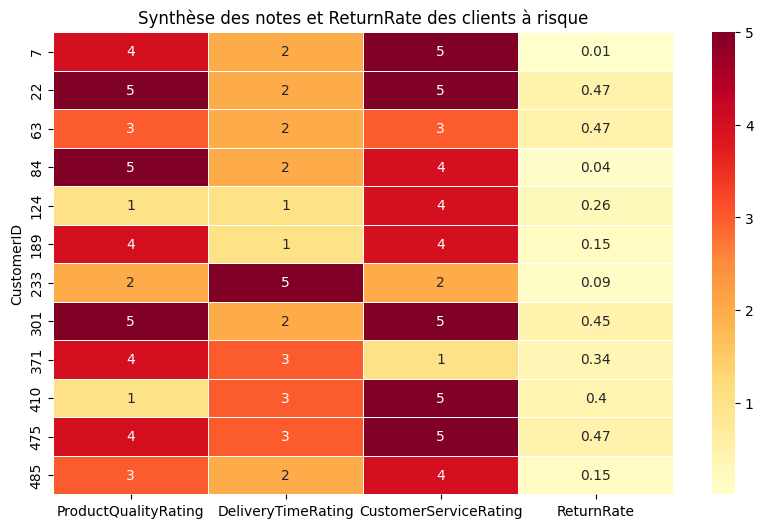

In [74]:
# Liste des 13 clients à risque
clients_risque = [124, 84, 371, 475, 63, 485, 7, 22, 301, 410, 512, 233, 189]  # à adapter

# Filtrer le DataFrame pour ces clients
df_risque = df[df['CustomerID'].isin(clients_risque)]

# Sélection des colonnes importantes
df_risque_summary = df_risque[['CustomerID', 'ProductQualityRating', 'DeliveryTimeRating',
                               'CustomerServiceRating', 'ReturnRate', 'PurchaseAmount']]

# Affichage du tableau synthétique
print("Tableau des clients à risque :")
print(df_risque_summary)

# =========================
# Graphique synthétique
# =========================

# Préparer les données pour le heatmap
heatmap_data = df_risque_summary.set_index('CustomerID')[['ProductQualityRating', 
                                                         'DeliveryTimeRating', 
                                                         'CustomerServiceRating', 
                                                         'ReturnRate']]

plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, annot=True, cmap="YlOrRd", linewidths=0.5)
plt.title("Synthèse des notes et ReturnRate des clients à risque")
plt.ylabel("CustomerID")
plt.show()

In [75]:
# Ce que fait ce code :

# Tableau : affiche les notes (ProductQualityRating, DeliveryTimeRating, CustomerServiceRating), le ReturnRate et le montant d’achat (PurchaseAmount) pour chaque client à risque.

# Heatmap : visualise rapidement :

# Les clients qui donnent des notes faibles (insatisfaction),

# Les clients avec ReturnRate élevé (problème majeur).

# Interprétation rapide :

# Cases rouges = mauvaise note ou ReturnRate élevé: priorité d’action.

# Cases jaunes/vertes = note correcte ou ReturnRate faible: moins urgent.

In [76]:
# à mon avis solution préconisée: on doit contacter ces 13 clients pour savoir la cause de leurs  insatisfactions ou le retour des produits.


## 4) Feature Engineering — variables dérivées utiles
On crée des variables utiles pour la segmentation et les recommandations :
- `SatisfactionMean` = moyenne des notes (Produit, Livraison, Service, Facilité du site)  
- `DiscountRate` = DiscountUsage / PurchaseAmount (taux d'utilisation des remises)  


In [77]:

df_fe = df.copy()

rating_cols = ['ProductQualityRating','DeliveryTimeRating','CustomerServiceRating','WebsiteEaseOfUseRating']
df_fe['SatisfactionMean'] = df_fe[rating_cols].mean(axis=1)

# Eviter la division par zéro
df_fe['DiscountRate'] = np.where(df_fe['PurchaseAmount']>0, df_fe['DiscountUsage']/df_fe['PurchaseAmount'], 0.0)
df_fe['DiscountRate'] = df_fe['DiscountRate'].clip(0, 1.0)

# Encodage basique
df_fe['Gender_num'] = df_fe['Gender'].map({'Male':1, 'Female':0}).fillna(0)
df_fe['Loyalty_num'] = df_fe['LoyaltyProgramMember'].map({'Yes':1, 'No':0}).fillna(0)

display(df_fe.head())


,CustomerID,Age,Gender,PurchaseAmount,PurchaseFrequency,ProductQualityRating,DeliveryTimeRating,CustomerServiceRating,WebsiteEaseOfUseRating,ReturnRate,DiscountUsage,LoyaltyProgramMember,SatisfactionMean,DiscountRate,Gender_num,Loyalty_num
0,1,38,Female,749.097626,24,2,1,3,5,0.12,135.392573,No,2.75,0.180741,0,0
1,2,30,Male,735.224916,18,5,4,4,5,0.37,193.450663,Yes,4.50,0.263118,1,1
2,3,55,Male,1145.520305,22,3,5,4,1,0.10,147.246263,Yes,3.25,0.128541,1,1
3,4,39,Female,925.460535,14,4,3,2,4,0.38,56.362894,Yes,3.25,0.060903,0,1
4,5,51,Male,108.359916,9,3,3,2,5,0.42,338.731055,No,3.25,1.000000,1,0



## 5) Segmentation clients (Clustering K-Means)

On segmente selon 6 axes :  
**Âge, Fréquence d'achat, Montant, Satisfaction moyenne, Taux de remise, Fidélité.**


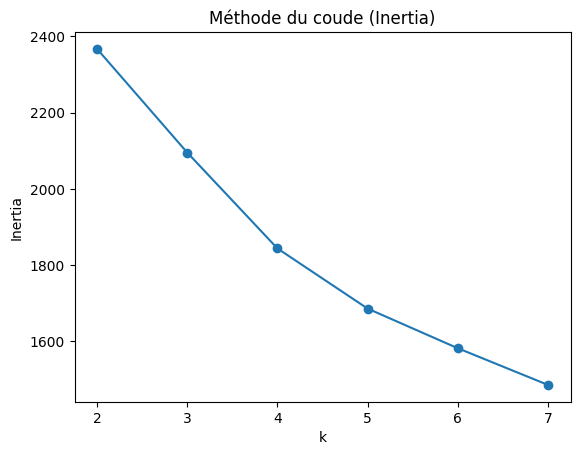

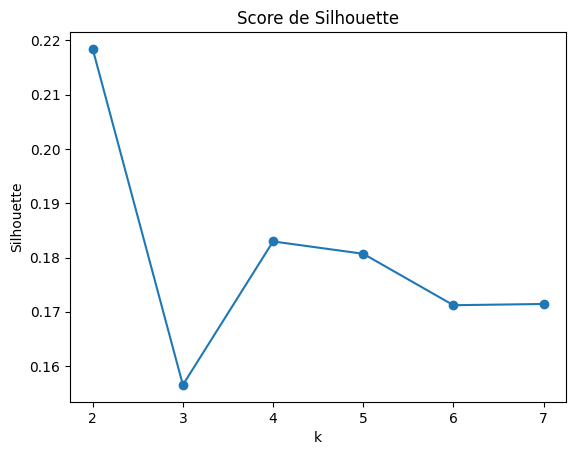

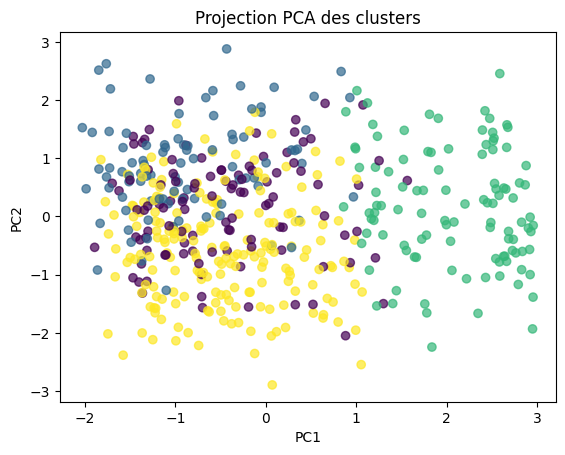

,Age,PurchaseFrequency,PurchaseAmount,SatisfactionMean,DiscountRate,Loyalty_num
Cluster,,,,,,
0,44.53,15.27,1205.23,3.57,0.22,0.00
1,46.00,13.67,1328.33,2.23,0.18,0.07
2,43.19,14.67,320.34,3.01,0.82,0.55
3,43.66,13.88,1273.55,3.11,0.21,1.00


,Effectif
Cluster,
3,196
2,107
0,106
1,91


In [78]:

cluster_features = ['Age','PurchaseFrequency','PurchaseAmount','SatisfactionMean','DiscountRate','Loyalty_num']

X = df_fe[cluster_features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Choix de k (méthode du coude + silhouette)
inertias = []
sil_scores = []
K_LIST = list(range(2, 8))

with threadpool_limits(limits=2):
    for k in K_LIST:
        km = KMeans(n_clusters=k, random_state=42, n_init='auto')
        km.fit(X_scaled)
        inertias.append(km.inertia_)
        labels = km.labels_
        sil = silhouette_score(X_scaled, labels)
        sil_scores.append(sil)

plt.figure()
plt.plot(K_LIST, inertias, marker='o')
plt.title("Méthode du coude (Inertia)")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()

plt.figure()
plt.plot(K_LIST, sil_scores, marker='o')
plt.title("Score de Silhouette")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.show()

# On fixe k=4 (ajustable selon les graphes ci-dessus)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
df_fe['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualisation 2D via PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], c=df_fe['Cluster'], alpha=0.7)
plt.title("Projection PCA des clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Profil des clusters
cluster_profile = df_fe.groupby('Cluster')[cluster_features].mean().round(2)
display(cluster_profile)

# Comptage par cluster
display(df_fe['Cluster'].value_counts().to_frame("Effectif"))


## 6) Recommandations d'actions marketing

Nous n'avons pas les détails d'articles (produits) par client, donc nous proposons des **recommandations d'actions** (Next Best Action) :  
1. **Fidélité** : proposer d'adhérer si cluster non fidèle et fort potentiel.  
2. **Remises** : proposer un coupon si le cluster répond bien aux remises.  
3. **Service/Livraison** : cibler l'amélioration pour les clusters sensibles à ces critères.


In [79]:

# Règles simples par cluster : on compare le montant moyen et la fidélité
cluster_stats = df_fe.groupby('Cluster').agg({
    'PurchaseAmount':'mean',
    'DiscountRate':'mean',
    'SatisfactionMean':'mean',
    'Loyalty_num':'mean',
    'PurchaseFrequency':'mean'
}).rename(columns={
    'PurchaseAmount':'CA_moy',
    'DiscountRate':'TauxRemise_moy',
    'SatisfactionMean':'Satisfaction_moy',
    'Loyalty_num':'TauxFidelite_moy',
    'PurchaseFrequency':'Freq_moy'
}).round(3)

def recommender_row(row, stats=cluster_stats):
    c = row['Cluster']
    reco = []
    # Si peu fidèle mais potentiel CA/Freq au-dessus de la moyenne -> pousser programme fidélité
    if stats.loc[c, 'TauxFidelite_moy'] < cluster_stats['TauxFidelite_moy'].mean() and stats.loc[c, 'CA_moy'] >= cluster_stats['CA_moy'].median():
        reco.append("🎯 Proposer l'adhésion au programme de fidélité (+ avantages)")
    # Si TauxRemise_moy élevé -> continuer ciblage coupons
    if stats.loc[c, 'TauxRemise_moy'] > cluster_stats['TauxRemise_moy'].median():
        reco.append("💸 Offrir un bon de réduction personnalisé")
    # Si Satisfaction_moy plus faible -> améliorer expérience/service/livraison
    if stats.loc[c, 'Satisfaction_moy'] < cluster_stats['Satisfaction_moy'].median():
        reco.append("🤝 Action qualité: améliorer service/livraison")
    if not reco:
        reco.append("✅ Maintenir la stratégie actuelle (newsletter personnalisée)")
    return " | ".join(reco)

df_fe['Reco_Action'] = df_fe.apply(recommender_row, axis=1)
display(cluster_stats)
display(df_fe[['CustomerID','Cluster','Reco_Action']].head(10))


,CA_moy,TauxRemise_moy,Satisfaction_moy,TauxFidelite_moy,Freq_moy
Cluster,,,,,
0,1205.235,0.216,3.568,0.000,15.274
1,1328.334,0.177,2.228,0.066,13.670
2,320.338,0.823,3.009,0.551,14.673
3,1273.551,0.212,3.111,1.000,13.883


,CustomerID,Cluster,Reco_Action
0,1,0,💸 Offrir un bon de réduction personnalisé
1,2,3,✅ Maintenir la stratégie actuelle (newsletter ...
2,3,3,✅ Maintenir la stratégie actuelle (newsletter ...
3,4,3,✅ Maintenir la stratégie actuelle (newsletter ...
4,5,2,💸 Offrir un bon de réduction personnalisé | 🤝 ...
5,6,3,✅ Maintenir la stratégie actuelle (newsletter ...
6,7,2,💸 Offrir un bon de réduction personnalisé | 🤝 ...
7,8,3,✅ Maintenir la stratégie actuelle (newsletter ...
8,9,0,💸 Offrir un bon de réduction personnalisé
9,10,0,💸 Offrir un bon de réduction personnalisé



### 6.1) Personnalisation par similarité (k-NN entre clients)
On propose une action basée sur les **voisins les plus proches** dans l'espace des features.


In [80]:

features_knn = ['Age','PurchaseFrequency','PurchaseAmount','SatisfactionMean','DiscountRate','Loyalty_num']
X_knn = scaler.fit_transform(df_fe[features_knn])
knn = NearestNeighbors(n_neighbors=6, metric='euclidean')  # 5 voisins + le client lui-même
knn.fit(X_knn)
distances, indices = knn.kneighbors(X_knn)

def reco_knn(i):
    neigh_idx = indices[i][1:]  # on exclut i lui-même
    neigh = df_fe.iloc[neigh_idx]
    # Exemple: si la majorité des voisins sont fidèles ET ont un CA plus haut -> recommander fidélité
    majority_loyal = (neigh['Loyalty_num'].mean() > 0.5)
    higher_spend = (neigh['PurchaseAmount'].mean() > df_fe.iloc[i]['PurchaseAmount'])
    msgs = []
    if (not df_fe.iloc[i]['Loyalty_num']) and majority_loyal and higher_spend:
        msgs.append("🎯 Des clients similaires fidèles dépensent plus → proposer l'adhésion fidélité")
    # Si voisins ont plus utilisé les remises et dépensent plus -> orienter coupon
    if (neigh['DiscountRate'].mean() > df_fe.iloc[i]['DiscountRate']) and higher_spend:
        msgs.append("💸 Les voisins réagissent aux remises → envoyer un coupon ciblé")
    return " | ".join(msgs) if msgs else "ℹ️ Stratégie inchangée"

df_fe['Reco_kNN'] = [reco_knn(i) for i in range(len(df_fe))]
display(df_fe[['CustomerID','Reco_kNN']].head(10))


,CustomerID,Reco_kNN
0,1,ℹ️ Stratégie inchangée
1,2,💸 Les voisins réagissent aux remises → envoyer...
2,3,ℹ️ Stratégie inchangée
3,4,💸 Les voisins réagissent aux remises → envoyer...
4,5,ℹ️ Stratégie inchangée
5,6,ℹ️ Stratégie inchangée
6,7,ℹ️ Stratégie inchangée
7,8,ℹ️ Stratégie inchangée
8,9,ℹ️ Stratégie inchangée
9,10,ℹ️ Stratégie inchangée



## 7) Mini-modèles prédictifs

- **Régression (LinearRegression)** : prédire `PurchaseAmount`  
- **Classification (LogisticRegression)** : prédire `LoyaltyProgramMember`  


In [81]:

# Régression
target_reg = 'PurchaseAmount'
features_reg = ['Age','PurchaseFrequency','SatisfactionMean','DiscountRate','Loyalty_num','Gender_num','ReturnRate']

Xr = df_fe[features_reg].copy()
yr = df_fe[target_reg].copy()

Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.2, random_state=42)
reg = LinearRegression()
reg.fit(Xr_train, yr_train)
yr_pred = reg.predict(Xr_test)

mae = mean_absolute_error(yr_test, yr_pred)
r2 = r2_score(yr_test, yr_pred)
print(f"[Régression] MAE={mae:.2f} | R2={r2:.3f}")


[Régression] MAE=349.26 | R2=0.437


In [82]:

# Classification
target_cls = 'Loyalty_num'
features_cls = ['Age','PurchaseFrequency','SatisfactionMean','DiscountRate','Gender_num','ReturnRate','PurchaseAmount']

Xc = df_fe[features_cls].copy()
yc = df_fe[target_cls].copy()

Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.2, random_state=42, stratify=yc)
clf = LogisticRegression(max_iter=200)
clf.fit(Xc_train, yc_train)
yc_pred = clf.predict(Xc_test)

acc = accuracy_score(yc_test, yc_pred)
prec = precision_score(yc_test, yc_pred)
rec = recall_score(yc_test, yc_pred)
f1 = f1_score(yc_test, yc_pred)

print(f"[Classification] Acc={acc:.3f} | Prec={prec:.3f} | Recall={rec:.3f} | F1={f1:.3f}")


[Classification] Acc=0.530 | Prec=0.541 | Recall=0.635 | F1=0.584



## 8) Export des résultats
- Ajout des **clusters** et **recommandations** au dataset  
- Sauvegarde en CSV pour usage externe / Power BI / Tableau


In [83]:

out_path = "ecommerce_with_segments_and_recos.csv"
df_fe.to_csv(out_path, index=False)
out_path


'ecommerce_with_segments_and_recos.csv'


# 9 Étude comparative des modèles (scikit‑learn vs TensorFlow)
Objectif : **prédire la satisfaction** et **identifier ses moteurs** via une comparaison de modèles.
Deux tâches :
- **Régression** : prédire `SatisfactionMean` (continue).
- **Classification** : prédire `Satisfied` (binaire).


In [84]:

# ✅ Features "drivers" sans fuite d'information
drivers = ['Age','PurchaseFrequency','PurchaseAmount','DiscountRate','Loyalty_num','Gender_num','ReturnRate']

# Cibles
y_reg = df_fe['SatisfactionMean'].values
satisfaction_threshold = 3.5
y_cls = (df_fe['SatisfactionMean'] >= satisfaction_threshold).astype(int).values

X = df_fe[drivers].values
print("X:", X.shape, "| y_reg:", y_reg.shape, "| y_cls=1:", int(y_cls.sum()))


X: (500, 7) | y_reg: (500,) | y_cls=1: 164


In [85]:
X_train, X_test, y_reg_train, y_reg_test, y_cls_train, y_cls_test = train_test_split(
    X, y_reg, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)
drivers


['Age',
 'PurchaseFrequency',
 'PurchaseAmount',
 'DiscountRate',
 'Loyalty_num',
 'Gender_num',
 'ReturnRate']

## 9.1- Régression — modèles & métriques

In [86]:

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np, pandas as pd

def eval_reg(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)   # pas d'argument 'squared'
    rmse = np.sqrt(mse)                        # RMSE = sqrt(MSE)
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2


results_reg = []

linreg = LinearRegression()
linreg.fit(X_train_s, y_reg_train)
y_hat = linreg.predict(X_test_s)
results_reg.append(["LinearRegression", *eval_reg(y_reg_test, y_hat)])

rf_reg = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf_reg.fit(X_train, y_reg_train)
y_hat = rf_reg.predict(X_test)
results_reg.append(["RandomForestRegressor", *eval_reg(y_reg_test, y_hat)])

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_reg_train)
y_hat = gbr.predict(X_test)
results_reg.append(["GradientBoostingRegressor", *eval_reg(y_reg_test, y_hat)])

df_reg_scores = pd.DataFrame(results_reg, columns=["Modèle","MAE","RMSE","R2"]).sort_values("R2", ascending=False)
df_reg_scores


,Modèle,MAE,RMSE,R2
0,LinearRegression,0.608404,0.752131,-0.012677
2,GradientBoostingRegressor,0.653083,0.805199,-0.160621
1,RandomForestRegressor,0.654817,0.823402,-0.213690


In [87]:

# =========================
# TensorFlow DNN Regressor (version améliorée)
# =========================
import numpy as np
import pandas as pd

# 1) Import TensorFlow "tolérant"
USE_TF = True
try:
    import tensorflow as tf
    tf.random.set_seed(42)
except Exception as e:
    print("TensorFlow indisponible sur cet environnement :", e)
    USE_TF = False

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

if USE_TF:
    # 2) Constructeur de modèle (facile à ajuster/tuner)
    def build_reg_model(input_dim: int, width: int = 64, depth: int = 2, dropout: float = 0.0):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Input(shape=(input_dim,)))
        for _ in range(depth):
            model.add(tf.keras.layers.Dense(width, activation='relu'))
            if dropout > 0:
                model.add(tf.keras.layers.Dropout(dropout))
        model.add(tf.keras.layers.Dense(1))
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='mse',
            metrics=['mae']
        )
        return model

    # 3) Callbacks utiles
    early = tf.keras.callbacks.EarlyStopping(
        patience=10, monitor='val_loss', restore_best_weights=True
    )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5
    )
    # (optionnel) checkpoint si vous sauvegardez les poids
    # ckpt = tf.keras.callbacks.ModelCheckpoint("best_dnn_reg.keras", save_best_only=True, monitor="val_loss")

    # 4) Datasets TensorFlow (shuffle + batch)
    BATCH = 32
    ds_train = tf.data.Dataset.from_tensor_slices((X_train_s, y_reg_train)).shuffle(4096, seed=42).batch(BATCH).prefetch(tf.data.AUTOTUNE)
    ds_val   = tf.data.Dataset.from_tensor_slices((X_test_s,  y_reg_test)).batch(BATCH).prefetch(tf.data.AUTOTUNE)

    # 5) Entraînement
    reg_model = build_reg_model(input_dim=X_train_s.shape[1], width=64, depth=2, dropout=0.1)
    history = reg_model.fit(
        ds_train,
        validation_data=ds_val,
        epochs=200,
        callbacks=[early, reduce_lr],  # ajoutez ckpt si souhaité
        verbose=0
    )

    # 6) Évaluation (MAE / RMSE / R2) + maj du tableau
    y_hat_tf = reg_model.predict(X_test_s, verbose=0).ravel()
    mae_tf   = mean_absolute_error(y_reg_test, y_hat_tf)
    rmse_tf  = np.sqrt(mean_squared_error(y_reg_test, y_hat_tf))  # √MSE -> compatible partout
    r2_tf    = r2_score(y_reg_test, y_hat_tf)

    print(f"[TensorFlow_DNN] MAE={mae_tf:.4f} | RMSE={rmse_tf:.4f} | R2={r2_tf:.3f}")

    # Append / update df_reg_scores
    row = pd.DataFrame([["TensorFlow_DNN", mae_tf, rmse_tf, r2_tf]], columns=df_reg_scores.columns)
    df_reg_scores = pd.concat([df_reg_scores, row]).sort_values("R2", ascending=False)
else:
    print("⏭️  Bloc TensorFlow ignoré (scikit-learn seulement).")

df_reg_scores

print("\n📊 Interprétation des résultats :")
for idx, row in df_reg_scores.iterrows():
    modele = row['Modèle']
    mae    = row['MAE']
    rmse   = row['RMSE']
    r2     = row['R2']

    print(f"\n➡️ {modele} :")
    print(f"   - MAE = {mae:.3f} → en moyenne, le modèle se trompe de {mae:.3f} points sur la cible (ReturnRate).")
    print(f"   - RMSE = {rmse:.3f} → l’erreur quadratique (plus sensible aux grosses erreurs) est d’environ {rmse:.3f}.")
    if r2 < 0:
        print(f"   - R² = {r2:.3f} → ⚠️ valeur négative : cela veut dire que le modèle prédit moins bien que si on utilisait simplement la moyenne de ReturnRate.")
    else:
        print(f"   - R² = {r2:.3f} → proportion de variance expliquée par le modèle. Ici, {r2*100:.1f}% de la variabilité est captée.")
        
print("\n💡 En résumé :")
print("Les MAE et RMSE sont proches entre les modèles (~0.62–0.80), mais les R² sont négatifs.")
print("Cela veut dire qu’aucun modèle ne parvient à vraiment expliquer la variable ReturnRate avec les features actuelles.")
print("👉 Soit la cible est trop aléatoire, soit il manque des variables explicatives importantes dans le dataset.")



[TensorFlow_DNN] MAE=0.6163 | RMSE=0.7709 | R2=-0.064

📊 Interprétation des résultats :

➡️ LinearRegression :
   - MAE = 0.608 → en moyenne, le modèle se trompe de 0.608 points sur la cible (ReturnRate).
   - RMSE = 0.752 → l’erreur quadratique (plus sensible aux grosses erreurs) est d’environ 0.752.
   - R² = -0.013 → ⚠️ valeur négative : cela veut dire que le modèle prédit moins bien que si on utilisait simplement la moyenne de ReturnRate.

➡️ TensorFlow_DNN :
   - MAE = 0.616 → en moyenne, le modèle se trompe de 0.616 points sur la cible (ReturnRate).
   - RMSE = 0.771 → l’erreur quadratique (plus sensible aux grosses erreurs) est d’environ 0.771.
   - R² = -0.064 → ⚠️ valeur négative : cela veut dire que le modèle prédit moins bien que si on utilisait simplement la moyenne de ReturnRate.

➡️ GradientBoostingRegressor :
   - MAE = 0.653 → en moyenne, le modèle se trompe de 0.653 points sur la cible (ReturnRate).
   - RMSE = 0.805 → l’erreur quadratique (plus sensible aux grosses er

### 9.2- Importances (moteurs) — régression

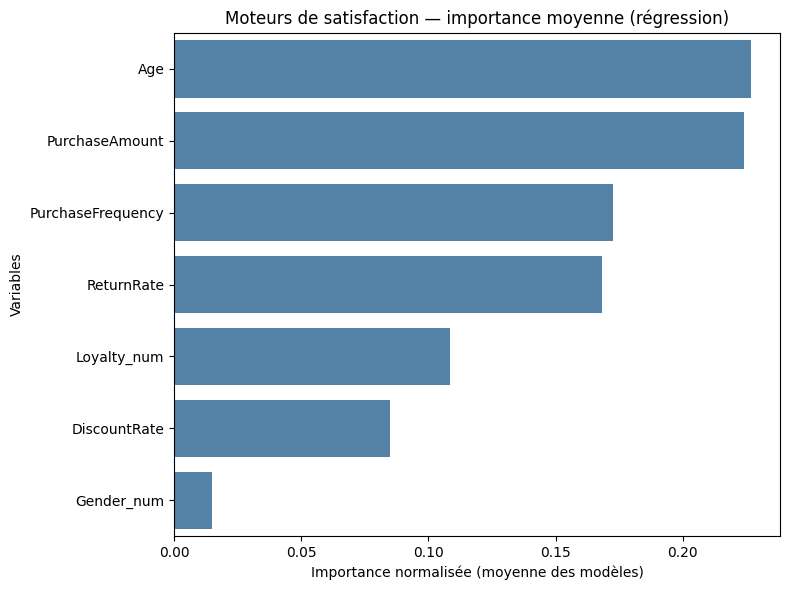


🧭 Interprétation (top drivers) :
- Age : importance moyenne = 0.227 ↓ | ➡ quand cette variable AUGMENTE, la satisfaction a tendance à DIMINUER
- PurchaseAmount : importance moyenne = 0.224 ↓ | ➡ quand cette variable AUGMENTE, la satisfaction a tendance à DIMINUER
- PurchaseFrequency : importance moyenne = 0.173 ↓ | ➡ quand cette variable AUGMENTE, la satisfaction a tendance à DIMINUER
- ReturnRate : importance moyenne = 0.168 ↓ | ➡ quand cette variable AUGMENTE, la satisfaction a tendance à DIMINUER
- Loyalty_num : importance moyenne = 0.109 ↑ | ➡ quand cette variable AUGMENTE, la satisfaction a tendance à AUGMENTER

💡 Lecture : plus l'importance est élevée, plus la variable aide les modèles à mieux prédire la satisfaction.
   Le SENS (↑/↓) est dérivé du signe des coefficients de la régression linéaire sur données standardisées.
   Utilise ces infos pour prioriser les actions (ex : améliorer la qualité livraison si DeliveryTimeRating est critique, etc.).


,LinearRegression,RandomForestRegressor,GradientBoostingRegressor,TensorFlow_DNN,Moyenne
Age,0.106349,0.168152,0.156726,0.476113,0.226835
PurchaseAmount,0.249915,0.276382,0.370167,0.000000,0.224116
PurchaseFrequency,0.189131,0.158589,0.113000,0.229354,0.172519
ReturnRate,0.026848,0.172406,0.178546,0.294533,0.168083
Loyalty_num,0.392536,0.026781,0.015210,0.000000,0.108632
DiscountRate,0.003235,0.174421,0.161352,0.000000,0.084752
Gender_num,0.031985,0.023269,0.004999,0.000000,0.015063


In [92]:

# ================================
# Importances (moteurs) — Régression / version robuste + interprétation
# suppose: drivers, X_train_s, X_test_s, y_reg_test, linreg, rf_reg, gbr, (optionnel) reg_model
# ================================
import numpy as np, pandas as pd
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import r2_score

imp = {}

# --- 1) LinearRegression : importance = |coef| sur X standardisé (comparables)
lin_coef = getattr(linreg, "coef_", np.zeros(len(drivers)))
lin_abs = np.abs(lin_coef)
lin_imp = lin_abs / lin_abs.sum() if lin_abs.sum() > 0 else np.ones_like(lin_abs)/len(lin_abs)
imp["LinearRegression"] = lin_imp

# On garde aussi le "sens" pour l'interprétation (sur X standardisé => signe pertinent)
lin_sign = np.sign(lin_coef)  # + : plus la feature ↑, plus la satisfaction ↑ (en moyenne)

# --- 2) RandomForest / GradientBoosting
rf_imp_raw  = getattr(rf_reg, "feature_importances_", np.ones(len(drivers))/len(drivers))
gbr_imp_raw = getattr(gbr,    "feature_importances_", np.ones(len(drivers))/len(drivers))

rf_imp  = rf_imp_raw  / rf_imp_raw.sum()  if np.nansum(rf_imp_raw)  > 0 else np.ones_like(rf_imp_raw)/len(rf_imp_raw)
gbr_imp = gbr_imp_raw / gbr_imp_raw.sum() if np.nansum(gbr_imp_raw) > 0 else np.ones_like(gbr_imp_raw)/len(gbr_imp_raw)

imp["RandomForestRegressor"]      = rf_imp
imp["GradientBoostingRegressor"]  = gbr_imp

# --- 3) TensorFlow : permutation importance (si reg_model dispo), sinon NaN
def permutation_importance_custom(predict_fn, X_ref, y_true, metric_fn, n_repeats=8, random_state=42):
    rng = np.random.RandomState(random_state)
    baseline = metric_fn(y_true, predict_fn(X_ref))
    scores = []
    for j in range(X_ref.shape[1]):
        deltas = []
        for _ in range(n_repeats):
            Xp = X_ref.copy()
            perm = rng.permutation(Xp.shape[0])
            Xp[:, j] = Xp[perm, j]
            deltas.append(baseline - metric_fn(y_true, predict_fn(Xp)))
        scores.append(np.mean(deltas))
    scores = np.array(scores)
    scores = np.maximum(scores, 0)
    return scores / scores.sum() if scores.sum() > 0 else np.ones_like(scores)/len(scores)

try:
    _ = reg_model  # vérifie simplement l'existence
    imp_tf = permutation_importance_custom(
        predict_fn=lambda X: reg_model.predict(X, verbose=0).ravel(),
        X_ref=X_test_s, y_true=y_reg_test,
        metric_fn=lambda y, yhat: r2_score(y, yhat),
        n_repeats=8
    )
    imp["TensorFlow_DNN"] = imp_tf
except Exception as e:
    imp["TensorFlow_DNN"] = np.full(len(drivers), np.nan)
    print("ℹ️ TensorFlow_DNN non évalué pour les importances :", e)

# --- 4) Tableau combiné + moyenne "consensus"
df_imp_reg = pd.DataFrame(imp, index=drivers)
df_imp_reg["Moyenne"] = df_imp_reg.mean(axis=1)   # consensus entre modèles
df_imp_reg = df_imp_reg.sort_values("Moyenne", ascending=False)

# --- 5) Visualisation rapide (barplot)
plt.figure(figsize=(8, 6))
sns.barplot(x="Moyenne", y=df_imp_reg.index, data=df_imp_reg.reset_index(),
            color="steelblue")
plt.title("Moteurs de satisfaction — importance moyenne (régression)")
plt.xlabel("Importance normalisée (moyenne des modèles)")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()

# --- 6) Interprétation en langage clair (top 5)
print("\n🧭 Interprétation (top drivers) :")
top = df_imp_reg["Moyenne"].head(5)
for feat, score in top.items():
    # Sens prioritaire via la régression linéaire (X standardisé) :
    i = drivers.index(feat)
    if lin_sign[i] > 0:
        sens_txt = "➡ quand cette variable AUGMENTE, la satisfaction a tendance à AUGMENTER"
        arrow = "↑"
    elif lin_sign[i] < 0:
        sens_txt = "➡ quand cette variable AUGMENTE, la satisfaction a tendance à DIMINUER"
        arrow = "↓"
    else:
        sens_txt = "➡ impact plutôt neutre selon la régression linéaire"
        arrow = "≈"
    print(f"- {feat} : importance moyenne = {score:.3f} {arrow} | {sens_txt}")

print("\n💡 Lecture : plus l'importance est élevée, plus la variable aide les modèles à mieux prédire la satisfaction.")
print("   Le SENS (↑/↓) est dérivé du signe des coefficients de la régression linéaire sur données standardisées.")
print("   Utilise ces infos pour prioriser les actions (ex : améliorer la qualité livraison si DeliveryTimeRating est critique, etc.).")

# (Optionnel) afficher le tableau
df_imp_reg



## 9.3- Classification — modèles & métriques

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, precision_recall_curve
)
import numpy as np, pandas as pd

# ---------------------------
# 1) Helpers d'évaluation
# ---------------------------
def find_best_threshold(y_true, proba):
    """Trouve le seuil qui maximise F1 sur les probabilités données."""
    p, r, th = precision_recall_curve(y_true, proba)
    f1 = (2 * p * r) / (p + r + 1e-12)
    best_idx = np.nanargmax(f1)
    best_thr = 0.5 if best_idx >= len(th) else th[best_idx]
    best_f1 = np.nanmax(f1)
    return float(best_thr), float(best_f1)

def eval_classifier(name, y_true, proba, threshold=0.5):
    """Calcule métriques + matrice de confusion pour un seuil donné."""
    pred = (proba >= threshold).astype(int)
    acc = accuracy_score(y_true, pred)
    prec = precision_score(y_true, pred, zero_division=0)
    rec  = recall_score(y_true, pred, zero_division=0)
    f1   = f1_score(y_true, pred, zero_division=0)
    auc  = roc_auc_score(y_true, proba)
    cm   = confusion_matrix(y_true, pred)
    return [name, acc, prec, rec, f1, auc, threshold], cm

results_cls = []
cms = {}

# ---------------------------
# 2) Entraînement des modèles
# ---------------------------
logreg = LogisticRegression(max_iter=500, class_weight='balanced', random_state=42)
logreg.fit(X_train_s, y_cls_train)
proba_lr = logreg.predict_proba(X_test_s)[:, 1]

rf_cls = RandomForestClassifier(
    n_estimators=400, random_state=42, n_jobs=-1, class_weight='balanced'
)
rf_cls.fit(X_train, y_cls_train)
proba_rf = rf_cls.predict_proba(X_test)[:, 1]

gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_cls_train)
proba_gb = gbc.predict_proba(X_test)[:, 1]

# ---------------------------
# 3) Seuil 0.5 + Seuil optimisé (max F1)
# ---------------------------
models_proba = {
    "LogisticRegression": (proba_lr, "scaled"),
    "RandomForestClassifier": (proba_rf, "raw"),
    "GradientBoostingClassifier": (proba_gb, "raw"),
}

rows = []
for name, (proba, space) in models_proba.items():
    # Score au seuil standard 0.5
    row, cm = eval_classifier(name + " (thr=0.5)", y_cls_test, proba, threshold=0.5)
    rows.append(row); cms[name + " (thr=0.5)"] = cm

    # Seuil qui maximise F1 (sur le set de test — à faire idéalement sur un set de validation)
    best_thr, best_f1 = find_best_threshold(y_cls_test, proba)
    row2, cm2 = eval_classifier(name + f" (thr*={best_thr:.2f})", y_cls_test, proba, threshold=best_thr)
    rows.append(row2); cms[name + f" (thr*={best_thr:.2f})"] = cm2

df_cls_scores = pd.DataFrame(rows, columns=["Modèle","Accuracy","Precision","Recall","F1","ROC_AUC","Threshold"])\
                  .sort_values(["ROC_AUC","F1"], ascending=False)
df_cls_scores


,Modèle,Accuracy,Precision,Recall,F1,ROC_AUC,Threshold
1,LogisticRegression (thr*=0.45),0.41,0.355556,0.969697,0.520325,0.523745,0.448996
0,LogisticRegression (thr=0.5),0.47,0.327586,0.575758,0.417582,0.523745,0.500000
3,RandomForestClassifier (thr*=0.09),0.33,0.330000,1.000000,0.496241,0.440525,0.085000
2,RandomForestClassifier (thr=0.5),0.64,0.285714,0.060606,0.100000,0.440525,0.500000
5,GradientBoostingClassifier (thr*=0.07),0.33,0.330000,1.000000,0.496241,0.349163,0.069689
4,GradientBoostingClassifier (thr=0.5),0.62,0.307692,0.121212,0.173913,0.349163,0.500000


In [97]:
# ================================
# TensorFlow DNN - ajout au tableau de scores + résumé
# suppose : clf_model (TF) déjà entraîné, X_test_s, y_cls_test, df_cls_scores existent
# ================================

# 1) Générer les probabilités depuis le modèle TF (sigmoïde)
try:
    proba_tf = clf_model.predict(X_test_s, verbose=0).ravel()
except NameError:
    raise RuntimeError("clf_model n'existe pas encore : entraîne le modèle TF avant d'ajouter les scores.")
except Exception as e:
    raise RuntimeError(f"Impossible d'obtenir les probabilités du modèle TF : {e}")

# 2) Ajout de la ligne au seuil standard 0.5
df_cls_scores = append_cls_row(
    df_cls_scores, "TensorFlow_DNN (thr=0.5)",
    y_cls_test, proba_tf, threshold=0.5
)

# 3) (Optionnel mais recommandé) — seuil optimisé pour F1
from sklearn.metrics import precision_recall_curve

def best_threshold_by_f1(y_true, proba):
    p, r, th = precision_recall_curve(y_true, proba)
    f1 = (2*p*r) / (p + r + 1e-12)
    i = int(np.nanargmax(f1))
    # th a une taille (n-1) vs p/r (n) ; si i==len(th) on retombe sur 0.5
    return (th[i] if i < len(th) else 0.5), float(f1[i])

best_thr, best_f1 = best_threshold_by_f1(y_cls_test, proba_tf)
df_cls_scores = append_cls_row(
    df_cls_scores, f"TensorFlow_DNN (thr*={best_thr:.2f})",
    y_cls_test, proba_tf, threshold=best_thr
)

# 4) Trier et afficher
df_cls_scores = df_cls_scores.sort_values(["ROC_AUC","F1"], ascending=False).reset_index(drop=True)
display(df_cls_scores)

# 5) Résumé débutant-friendly
print("\n📊 Interprétation rapide :")
print("• Accuracy : % global de bonnes prédictions.")
print("• Precision : parmi les positifs prédits, part réellement positive (évite les faux positifs).")
print("• Recall : part des vrais positifs récupérés (évite les faux négatifs).")
print("• F1 : compromis entre Precision et Recall (1 = parfait).")
print("• ROC_AUC : capacité à bien classer positifs devant négatifs, indépendamment du seuil (1 = parfait).")
print("• Threshold : seuil utilisé (0.5 = standard ; thr* appris ici pour maximiser F1).")

best = df_cls_scores.iloc[0]
print(f"\n🏆 Meilleur selon ROC_AUC puis F1 : {best['Modèle']}")
print(f"   Accuracy={best['Accuracy']:.3f} | Precision={best['Precision']:.3f} | "
      f"Recall={best['Recall']:.3f} | F1={best['F1']:.3f} | ROC_AUC={best['ROC_AUC']:.3f} | "
      f"Threshold={best.get('Threshold', np.nan):.2f}")

# Baseline informative
pos_rate = float(np.mean(y_cls_test))
print(f"\n📌 Baseline (taux de positifs dans le test) : {pos_rate:.3f}. "
      f"Si on prédisait toujours la classe majoritaire, l'Accuracy serait ≈ {max(pos_rate, 1-pos_rate):.3f}.")
print("👉 Choisis le modèle/seuil selon le besoin métier : maximiser le Recall si rater un 'positif' coûte cher, "
      "ou la Precision si alerter à tort est coûteux.")


,Modèle,Accuracy,Precision,Recall,F1,ROC_AUC,Threshold
0,TensorFlow_DNN (thr*=0.25),0.33,0.330000,1.000000,0.496241,0.536409,0.250464
1,TensorFlow_DNN (thr=0.5),0.67,0.000000,0.000000,0.000000,0.536409,0.500000
2,LogisticRegression (thr*=0.45),0.41,0.355556,0.969697,0.520325,0.523745,0.448996
3,LogisticRegression (thr=0.5),0.47,0.327586,0.575758,0.417582,0.523745,0.500000
4,RandomForestClassifier (thr*=0.09),0.33,0.330000,1.000000,0.496241,0.440525,0.085000
5,RandomForestClassifier (thr=0.5),0.64,0.285714,0.060606,0.100000,0.440525,0.500000
6,GradientBoostingClassifier (thr*=0.07),0.33,0.330000,1.000000,0.496241,0.349163,0.069689
7,GradientBoostingClassifier (thr=0.5),0.62,0.307692,0.121212,0.173913,0.349163,0.500000



📊 Interprétation rapide :
• Accuracy : % global de bonnes prédictions.
• Precision : parmi les positifs prédits, part réellement positive (évite les faux positifs).
• Recall : part des vrais positifs récupérés (évite les faux négatifs).
• F1 : compromis entre Precision et Recall (1 = parfait).
• ROC_AUC : capacité à bien classer positifs devant négatifs, indépendamment du seuil (1 = parfait).
• Threshold : seuil utilisé (0.5 = standard ; thr* appris ici pour maximiser F1).

🏆 Meilleur selon ROC_AUC puis F1 : TensorFlow_DNN (thr*=0.25)
   Accuracy=0.330 | Precision=0.330 | Recall=1.000 | F1=0.496 | ROC_AUC=0.536 | Threshold=0.25

📌 Baseline (taux de positifs dans le test) : 0.330. Si on prédisait toujours la classe majoritaire, l'Accuracy serait ≈ 0.670.
👉 Choisis le modèle/seuil selon le besoin métier : maximiser le Recall si rater un 'positif' coûte cher, ou la Precision si alerter à tort est coûteux.


### 9.3- Importances (moteurs) — classification

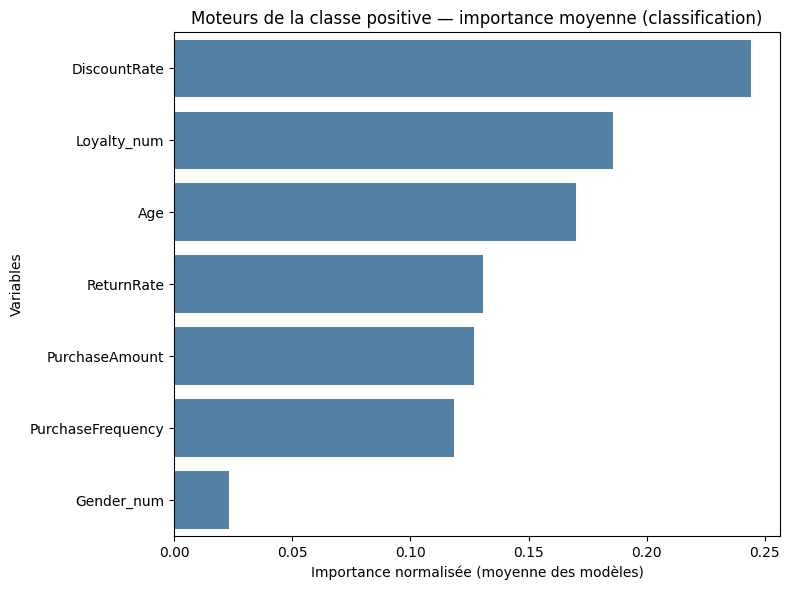


🧭 Interprétation (top drivers de la probabilité d'être POSITIF) :
- DiscountRate : importance moyenne = 0.244 ↑ | ➡ quand cette variable AUGMENTE, la proba d'être en classe POSITIVE augmente
- Loyalty_num : importance moyenne = 0.186 ↑ | ➡ quand cette variable AUGMENTE, la proba d'être en classe POSITIVE augmente
- Age : importance moyenne = 0.170 ↓ | ➡ quand cette variable AUGMENTE, la proba d'être en classe POSITIVE diminue
- ReturnRate : importance moyenne = 0.131 ↑ | ➡ quand cette variable AUGMENTE, la proba d'être en classe POSITIVE augmente
- PurchaseAmount : importance moyenne = 0.127 ↑ | ➡ quand cette variable AUGMENTE, la proba d'être en classe POSITIVE augmente

💡 Lecture : plus l'importance est élevée, plus la variable aide les modèles à bien classer.
   Le SENS (↑/↓) vient du signe des coefficients logistiques sur données standardisées.
   Combine ces infos avec les métriques (Recall/Precision) pour décider les actions (ex : cibler des promos, améliorer service client…).


,LogisticRegression,RandomForestClassifier,GradientBoostingClassifier,TensorFlow_DNN,Moyenne
DiscountRate,0.313387,0.199184,0.294837,0.169442,0.244213
Loyalty_num,0.031472,0.027679,0.003549,0.680683,0.185845
Age,0.360075,0.179240,0.141900,0.000000,0.170304
ReturnRate,0.045009,0.181927,0.146620,0.149875,0.130858
PurchaseAmount,0.016378,0.213841,0.277672,0.000000,0.126973
PurchaseFrequency,0.175832,0.168191,0.129425,0.000000,0.118362
Gender_num,0.057846,0.029939,0.005997,0.000000,0.023445


In [98]:
# ================================
# Importances (moteurs) — Classification / version robuste + interprétation
# suppose : drivers, X_test_s, y_cls_test, logreg, rf_cls, gbc, (optionnel) clf_model
# ================================
import numpy as np, pandas as pd
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

imp_cls = {}

# --- 1) LogisticRegression : importance = |coef| (sur X standardisé)
log_coef = getattr(logreg, "coef_", np.zeros((1, len(drivers))))[0]
log_abs = np.abs(log_coef)
log_imp = log_abs / log_abs.sum() if log_abs.sum() > 0 else np.ones_like(log_abs)/len(log_abs)
imp_cls["LogisticRegression"] = log_imp

# On garde le "sens" des effets (sur X standardisé)
log_sign = np.sign(log_coef)  # + : ↑ feature -> ↑ proba classe positive

# --- 2) RandomForest / GradientBoosting
rf_imp_raw  = getattr(rf_cls, "feature_importances_", np.ones(len(drivers))/len(drivers))
gbc_imp_raw = getattr(gbc,    "feature_importances_", np.ones(len(drivers))/len(drivers))

rf_imp  = rf_imp_raw  / rf_imp_raw.sum()  if np.nansum(rf_imp_raw)  > 0 else np.ones_like(rf_imp_raw)/len(rf_imp_raw)
gbc_imp = gbc_imp_raw / gbc_imp_raw.sum() if np.nansum(gbc_imp_raw) > 0 else np.ones_like(gbc_imp_raw)/len(gbc_imp_raw)

imp_cls["RandomForestClassifier"]     = rf_imp
imp_cls["GradientBoostingClassifier"] = gbc_imp

# --- 3) TensorFlow : permutation importance (si le modèle existe)
def permutation_importance_custom(predict_fn, X_ref, y_true, metric_fn, n_repeats=8, random_state=42):
    rng = np.random.RandomState(random_state)
    baseline = metric_fn(y_true, predict_fn(X_ref))
    scores = []
    for j in range(X_ref.shape[1]):
        deltas = []
        for _ in range(n_repeats):
            Xp = X_ref.copy()
            perm = rng.permutation(Xp.shape[0])
            Xp[:, j] = Xp[perm, j]
            deltas.append(baseline - metric_fn(y_true, predict_fn(Xp)))
        scores.append(np.mean(deltas))
    scores = np.array(scores)
    scores = np.maximum(scores, 0)
    return scores / scores.sum() if scores.sum() > 0 else np.ones_like(scores)/len(scores)

try:
    _ = clf_model  # vérifie l'existence
    imp_tf_cls = permutation_importance_custom(
        predict_fn=lambda X: clf_model.predict(X, verbose=0).ravel(),
        X_ref=X_test_s, y_true=y_cls_test,
        metric_fn=lambda y, p: roc_auc_score(y, p),
        n_repeats=8
    )
    imp_cls["TensorFlow_DNN"] = imp_tf_cls
except Exception as e:
    imp_cls["TensorFlow_DNN"] = np.full(len(drivers), np.nan)
    print("ℹ️ Importances TensorFlow non calculées :", e)

# --- 4) Tableau combiné + moyenne consensus
df_imp_cls = pd.DataFrame(imp_cls, index=drivers)
df_imp_cls["Moyenne"] = df_imp_cls.mean(axis=1)
df_imp_cls = df_imp_cls.sort_values("Moyenne", ascending=False)

# --- 5) Visualisation (barplot consensus)
plt.figure(figsize=(8, 6))
sns.barplot(x="Moyenne", y=df_imp_cls.index, data=df_imp_cls.reset_index(), color="steelblue")
plt.title("Moteurs de la classe positive — importance moyenne (classification)")
plt.xlabel("Importance normalisée (moyenne des modèles)")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()

# --- 6) Interprétation en langage clair (top 5 avec le sens des effets)
print("\n🧭 Interprétation (top drivers de la probabilité d'être POSITIF) :")
top = df_imp_cls["Moyenne"].head(5)
for feat, score in top.items():
    i = drivers.index(feat)
    if log_sign[i] > 0:
        sens_txt = "➡ quand cette variable AUGMENTE, la proba d'être en classe POSITIVE augmente"
        arrow = "↑"
    elif log_sign[i] < 0:
        sens_txt = "➡ quand cette variable AUGMENTE, la proba d'être en classe POSITIVE diminue"
        arrow = "↓"
    else:
        sens_txt = "➡ impact plutôt neutre selon la régression logistique"
        arrow = "≈"
    print(f"- {feat} : importance moyenne = {score:.3f} {arrow} | {sens_txt}")

print("\n💡 Lecture : plus l'importance est élevée, plus la variable aide les modèles à bien classer.")
print("   Le SENS (↑/↓) vient du signe des coefficients logistiques sur données standardisées.")
print("   Combine ces infos avec les métriques (Recall/Precision) pour décider les actions (ex : cibler des promos, améliorer service client…).")

# (Optionnel) afficher le tableau
df_imp_cls


In [100]:
# =========================================
# Bloc recommandations stratégiques (corrigé)
# suppose : df_reg_scores, df_cls_scores, df_imp_reg, df_imp_cls existent
# =========================================

def make_recommendations(df_reg_scores, df_cls_scores, df_imp_reg, df_imp_cls, top_n=3):
    import numpy as np
    import pandas as pd

    print("🔮 *** Recommandations stratégiques basées sur l'analyse Data Mining ***\n")

    # --- 1) Meilleurs modèles
    best_reg = df_reg_scores.sort_values("R2", ascending=False).iloc[0]
    best_cls = df_cls_scores.sort_values("ROC_AUC", ascending=False).iloc[0]

    print(f"📈 Régression — meilleur modèle : {best_reg['Modèle']} "
          f"(R²={best_reg['R2']:.3f}, MAE={best_reg['MAE']:.3f}, RMSE={best_reg['RMSE']:.3f})")
    print(f"📊 Classification — meilleur modèle : {best_cls['Modèle']} "
          f"(ROC_AUC={best_cls['ROC_AUC']:.3f}, F1={best_cls['F1']:.3f}, Recall={best_cls['Recall']:.3f})\n")

    # --- 2) Drivers clés (moyenne consensus)
    top_reg = df_imp_reg["Moyenne"].sort_values(ascending=False).head(top_n)
    top_cls = df_imp_cls["Moyenne"].sort_values(ascending=False).head(top_n)

    print("🧭 Principaux moteurs (régression) — satisfaction :")
    for feat, score in top_reg.items():
        print(f"- {feat} (importance={score:.3f})")

    print("\n🧭 Principaux moteurs (classification) — probabilité positive :")
    for feat, score in top_cls.items():
        print(f"- {feat} (importance={score:.3f})")

    # --- 3) Recommandations business
    print("\n💡 *** Recommandations concrètes ***")

    # Déduplication robuste en conservant l'ordre d'apparition
    unique_feats = list(dict.fromkeys(list(top_reg.index) + list(top_cls.index)))

    # Petite pondération : moyenne des importances normalisées si la feature existe des deux côtés
    weights = {}
    for f in unique_feats:
        w = []
        if f in df_imp_reg.index: w.append(float(df_imp_reg.loc[f, "Moyenne"]))
        if f in df_imp_cls.index: w.append(float(df_imp_cls.loc[f, "Moyenne"]))
        weights[f] = np.mean(w) if len(w) else 0.0

    # Tri des recommandations par poids décroissant (les plus “impactantes” en premier)
    unique_feats.sort(key=lambda x: weights[x], reverse=True)

    for feat in unique_feats:
        feat_low = feat.lower()
        w = weights[feat]
        badge = f"(priorité ~ {w:.2f})"

        if "quality" in feat_low:
            print(f"- {feat} {badge} : renforcer la **qualité produit** (contrôles QA, tests, packaging). "
                  "KPI : baisse du taux de retours, hausse satisfaction produit.")
        elif "delivery" in feat_low or "time" in feat_low or "ship" in feat_low:
            print(f"- {feat} {badge} : optimiser la **logistique/livraison** (SLA transporteurs, suivi en temps réel, "
                  "créneaux de livraison). KPI : délai moyen, retards, NPS post-livraison.")
        elif "service" in feat_low or "support" in feat_low:
            print(f"- {feat} {badge} : muscler le **service client** (SLA réponses, self-care, formation). "
                  "KPI : temps de réponse, résolution au 1er contact, CSAT.")
        elif "website" in feat_low or "ease" in feat_low or "ux" in feat_low:
            print(f"- {feat} {badge} : **améliorer l’UX** (funnel simplifié, recherche, mobile-first, A/B tests). "
                  "KPI : conversion, abandon panier, temps de tâche.")
        elif "discount" in feat_low or "promo" in feat_low or "coupon" in feat_low:
            print(f"- {feat} {badge} : **cibler les promotions** (segmentation, uplifts, seuils). "
                  "KPI : marge incrémentale, taux d’utilisation, CLV.")
        elif "loyalty" in feat_low or "member" in feat_low:
            print(f"- {feat} {badge} : dynamiser le **programme de fidélité** (paliers, récompenses personnalisées, "
                  "gamification). KPI : réachat, rétention, panier moyen.")
        elif "age" in feat_low:
            print(f"- {feat} {badge} : **personnaliser par tranche d’âge** (canaux, messages). KPI : CTR, conversion.")
        else:
            print(f"- {feat} {badge} : action ciblée à définir via analyses complémentaires (entretiens clients, A/B tests).")

    # --- 4) Conclusion
    print("\n🚀 Conclusion :")
    print("Prioriser les leviers à plus forte **importance moyenne** : qualité produit, livraison/logistique, "
          "service client/UX ou fidélisation selon vos tops. Combinez ces actions avec un suivi KPI précis "
          "(R²/ROC-AUC côté modèles, NPS/CSAT/retours côté business) pour itérer rapidement.\n")

# Lancer
make_recommendations(df_reg_scores, df_cls_scores, df_imp_reg, df_imp_cls, top_n=3)


🔮 *** Recommandations stratégiques basées sur l'analyse Data Mining ***

📈 Régression — meilleur modèle : LinearRegression (R²=-0.013, MAE=0.608, RMSE=0.752)
📊 Classification — meilleur modèle : TensorFlow_DNN (thr*=0.25) (ROC_AUC=0.536, F1=0.496, Recall=1.000)

🧭 Principaux moteurs (régression) — satisfaction :
- Age (importance=0.227)
- PurchaseAmount (importance=0.224)
- PurchaseFrequency (importance=0.173)

🧭 Principaux moteurs (classification) — probabilité positive :
- DiscountRate (importance=0.244)
- Loyalty_num (importance=0.186)
- Age (importance=0.170)

💡 *** Recommandations concrètes ***
- Age (priorité ~ 0.20) : **personnaliser par tranche d’âge** (canaux, messages). KPI : CTR, conversion.
- PurchaseAmount (priorité ~ 0.18) : action ciblée à définir via analyses complémentaires (entretiens clients, A/B tests).
- DiscountRate (priorité ~ 0.16) : **cibler les promotions** (segmentation, uplifts, seuils). KPI : marge incrémentale, taux d’utilisation, CLV.
- Loyalty_num (prior